In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
# list cuda devices
print("Available CUDA devices:")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Available CUDA devices:
Device 0: NVIDIA RTX A5500


## Recurrent network simulation

In [3]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of RNN models
class MC_RNN_Dataset(Dataset):
    def __init__(self, data, labels, frame_num=32, chan_num=2):
        """
        Args:
            data (np.ndarray): Array of shape (num_samples, num_frames, height, width)
            labels (np.ndarray): Array of shape (num_samples,) with labels
            frame_num (int): Number of frames to stack for input as multichannel image
            chan_num (int): Number of channels in the input images. Each channel is a 
            previous frame.
        """

        self.data = data
        self.labels = labels[['fg_char_id', 'fg_char_x', 'fg_char_y']].values
        self.frame_num = frame_num
        self.chan_num = chan_num

    def __len__(self):
        return (self.data.shape[0]-self.chan_num) // self.frame_num

    def __getitem__(self, idx):
        start_idx = (idx * self.frame_num) + self.chan_num
        end_idx = start_idx + self.frame_num

        # Stack frames to create a multichannel image
        for i in range(-(self.chan_num-1), 1):
            if i == -(self.chan_num-1):
                stacked_frames = np.expand_dims(self.data[(start_idx + i):(end_idx + i)], axis=1)
            else:
                stacked_frames = np.concatenate((stacked_frames, 
                                                 np.expand_dims(self.data[(start_idx + i):(end_idx + i)], 
                                                                axis=1)), axis=1)
        stacked_frames = stacked_frames.astype(np.float32)

        # insert channel dimension
        labels = self.labels[start_idx:end_idx]
        return stacked_frames, labels


In [73]:
# train feedforward network
def network_train(mdl, train_data, val_data, num_epochs=50, loss_weights=[1, 0.01], lr=0.001):
    mdl.to('cuda')
    optim = torch.optim.Adam(mdl.parameters(), lr=lr)
    criterion_char = nn.CrossEntropyLoss()
    criterion_pos = nn.MSELoss()
    
    # Define loss functions
    def loss_fn(out_char, out_pos, labels):
        labels_char = labels[:, :, 0].long().view(-1)
        labels_pos = labels[:, :, 1:].float().view(-1, 2)
        outputs_char = out_char.view(-1, out_char.shape[-1])
        outputs_pos = out_pos.view(-1, out_pos.shape[-1])
        loss_char = criterion_char(outputs_char, labels_char)
        loss_pos = criterion_pos(outputs_pos, labels_pos)
        rnn_hh = mdl.rnn.weight_hh_l0
        # sum elements along diagonal of rnn_hh
        rnn_hh_diag = torch.diagonal(rnn_hh).abs().sum()
        loss = (loss_weights[0] * loss_char) + (loss_weights[1] * loss_pos) + rnn_hh_diag
        return loss

    def evaluate(mdl, data_loader):
        mdl.eval()
        total_acc_char = 0
        total_err_pos = 0
        with torch.no_grad():
            for batch in data_loader:
                inputs, labels = batch
                labels = labels.to(mdl.device)
                out_char, out_pos = mdl(inputs)
                total_acc_char += (torch.argmax(out_char, dim=2) == labels[:, :, 0].long()).float().mean().item()
                total_err_pos += F.mse_loss(out_pos, labels[:, :, 1:].float(), reduction='mean').item()
        return total_acc_char*100 / len(data_loader), total_err_pos / len(data_loader)

    # data loader
    train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_data, batch_size=32, shuffle=True)
    train_acc_char = np.zeros(num_epochs)
    val_acc_char = np.zeros(num_epochs)
    train_err_pos = np.zeros(num_epochs)
    val_err_pos = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        mdl.train()
        for batch in train_dl:
            inputs, labels = batch
            labels = labels.to(mdl.device)            
            optim.zero_grad()
            out_char, out_pos = mdl(inputs)
            loss = loss_fn(out_char, out_pos, labels)
            loss.backward()
            optim.step()
            train_acc_char[epoch] += (torch.argmax(out_char, dim=2) == labels[:, :, 0].long()).float().mean().item()
            train_err_pos[epoch] += F.mse_loss(out_pos, labels[:, :, 1:].float(), reduction='mean').item()

        train_acc_char[epoch] /= len(train_dl)
        train_acc_char[epoch] *= 100  # Convert to percentage
        train_err_pos[epoch] /= len(train_dl)
        train_str = f"Epoch {epoch + 1}/{num_epochs} - Train (char, pos): ({train_acc_char[epoch]:.2f}%, {train_err_pos[epoch]:.2f} pix^2)"

        # Print accuracy on character id for validation data
        with torch.no_grad():
            val_acc_char[epoch], val_err_pos[epoch] = evaluate(mdl, val_dl)
            val_str = f" Validation (char, pos): ({val_acc_char[epoch]:.2f}%, {val_err_pos[epoch]:.2f} pix^2)"
            print(train_str, val_str)

    torch.cuda.empty_cache()

    return {
        "train_acc_char": train_acc_char,
        "val_acc_char": val_acc_char,
        "train_err_pos": train_err_pos,
        "val_err_pos": val_err_pos,
        "model": mdl.to("cpu")
    }

In [39]:
# calculate module parameter count
def model_param_count(mdl):
    return sum(p.numel() for p in mdl.parameters() if p.requires_grad)


In [74]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConv(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.RNN(input_size=64 * 12 * 12, hidden_size=256, 
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(256)
        self.fcchar = nn.Linear(256, num_classes)
        self.fcpos = nn.Linear(256, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnn(x)[0]
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [75]:
stim_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.npy"
label_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.npy"
label_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConv(num_classes=10, num_pos=2, kernel_size=5)
print(f"RNN model parameter count: {model_param_count(mdl_rnn)}")
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

RNN model parameter count: 2614956
Epoch 1/50 - Train (char, pos): (10.15%, 1053.20 pix^2)  Validation (char, pos): (10.15%, 418.26 pix^2)
Epoch 2/50 - Train (char, pos): (11.18%, 360.25 pix^2)  Validation (char, pos): (11.90%, 338.97 pix^2)
Epoch 3/50 - Train (char, pos): (16.95%, 296.15 pix^2)  Validation (char, pos): (19.52%, 279.97 pix^2)
Epoch 4/50 - Train (char, pos): (22.83%, 261.34 pix^2)  Validation (char, pos): (23.04%, 245.62 pix^2)
Epoch 5/50 - Train (char, pos): (31.01%, 233.34 pix^2)  Validation (char, pos): (28.23%, 220.78 pix^2)
Epoch 6/50 - Train (char, pos): (40.43%, 205.09 pix^2)  Validation (char, pos): (40.77%, 196.75 pix^2)
Epoch 7/50 - Train (char, pos): (50.09%, 189.00 pix^2)  Validation (char, pos): (43.79%, 193.38 pix^2)
Epoch 8/50 - Train (char, pos): (58.73%, 174.15 pix^2)  Validation (char, pos): (46.56%, 189.14 pix^2)
Epoch 9/50 - Train (char, pos): (66.07%, 163.07 pix^2)  Validation (char, pos): (51.86%, 177.69 pix^2)
Epoch 10/50 - Train (char, pos): (72.

2614956

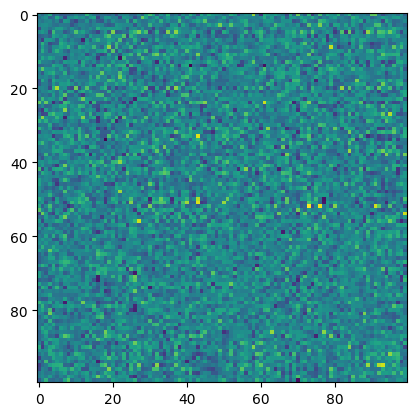

In [82]:
params = list(mdl_rnn.rnn.parameters())[1].cpu().detach().numpy()
plt.imshow(params[:100,:100])

In [87]:
U,S,V = np.linalg.svd(params, full_matrices=False)

## Two-layer stacked RNN

In [54]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvStack(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvStack, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.RNN(input_size=64 * 12 * 12, hidden_size=240, 
                          num_layers=2, batch_first=True, dropout=0.5)
        self.LNormRNN = nn.LayerNorm(240)
        self.fcchar = nn.Linear(240, num_classes)
        self.fcpos = nn.Linear(240, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnn(x)[0]
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [55]:
stim_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.npy"
label_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.npy"
label_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvStack(num_classes=10, num_pos=2, kernel_size=5)
print(f"RNN model parameter count: {model_param_count(mdl_rnn)}")
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

RNN model parameter count: 2574988
Epoch 1/50 - Train (char, pos): (10.17%, 1044.88 pix^2)  Validation (char, pos): (9.93%, 437.34 pix^2)
Epoch 2/50 - Train (char, pos): (10.33%, 381.28 pix^2)  Validation (char, pos): (10.55%, 333.24 pix^2)
Epoch 3/50 - Train (char, pos): (10.48%, 261.57 pix^2)  Validation (char, pos): (11.30%, 184.40 pix^2)
Epoch 4/50 - Train (char, pos): (10.31%, 189.89 pix^2)  Validation (char, pos): (9.89%, 159.15 pix^2)
Epoch 5/50 - Train (char, pos): (13.64%, 167.69 pix^2)  Validation (char, pos): (17.55%, 156.85 pix^2)
Epoch 6/50 - Train (char, pos): (19.28%, 162.05 pix^2)  Validation (char, pos): (20.49%, 145.13 pix^2)
Epoch 7/50 - Train (char, pos): (21.94%, 151.61 pix^2)  Validation (char, pos): (20.92%, 136.54 pix^2)
Epoch 8/50 - Train (char, pos): (24.22%, 151.23 pix^2)  Validation (char, pos): (23.73%, 138.65 pix^2)
Epoch 9/50 - Train (char, pos): (27.50%, 141.90 pix^2)  Validation (char, pos): (28.30%, 133.79 pix^2)
Epoch 10/50 - Train (char, pos): (31.24

## Split RNN, split classification
RNNs are separated into distinct classification channels

In [61]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvSplitDisc(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvSplitDisc, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnnchar = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.rnnpos = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.LNormRNNPos = nn.LayerNorm(128)
        self.LNormRNNChar = nn.LayerNorm(128)
        self.fcchar = nn.Linear(128, num_classes)
        self.fcpos = nn.Linear(128, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        xchar = self.rnnchar(x)[0]
        xpos = self.rnnpos(x)[0]
        xchar = self.LNormRNNChar(xchar)
        xpos = self.LNormRNNPos(xpos)
        xchar = nn.Dropout(0.5)(nn.ReLU()(xchar))
        xpos = nn.Dropout(0.5)(nn.ReLU()(xpos))
        return xchar, xpos

    def classifier(self, xc, xp):
        return self.fcchar(xc), self.fcpos(xp)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        xc, xp = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(xc, xp)
        return char_out, pos_out

In [62]:
stim_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.npy"
label_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.npy"
label_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvSplitDisc(num_classes=10, num_pos=2, kernel_size=5)
print(f"RNN model parameter count: {model_param_count(mdl_rnn)}")
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

RNN model parameter count: 2580652
Epoch 1/50 - Train (char, pos): (10.36%, 1399.52 pix^2)  Validation (char, pos): (10.49%, 614.85 pix^2)
Epoch 2/50 - Train (char, pos): (11.01%, 461.18 pix^2)  Validation (char, pos): (10.44%, 428.46 pix^2)
Epoch 3/50 - Train (char, pos): (12.67%, 381.31 pix^2)  Validation (char, pos): (13.81%, 339.84 pix^2)
Epoch 4/50 - Train (char, pos): (18.04%, 295.52 pix^2)  Validation (char, pos): (16.14%, 271.65 pix^2)
Epoch 5/50 - Train (char, pos): (20.53%, 246.13 pix^2)  Validation (char, pos): (21.47%, 216.93 pix^2)
Epoch 6/50 - Train (char, pos): (25.78%, 206.18 pix^2)  Validation (char, pos): (26.76%, 189.22 pix^2)
Epoch 7/50 - Train (char, pos): (29.89%, 184.58 pix^2)  Validation (char, pos): (29.54%, 177.54 pix^2)
Epoch 8/50 - Train (char, pos): (35.29%, 168.03 pix^2)  Validation (char, pos): (34.12%, 161.81 pix^2)
Epoch 9/50 - Train (char, pos): (41.45%, 154.15 pix^2)  Validation (char, pos): (35.79%, 165.53 pix^2)
Epoch 10/50 - Train (char, pos): (46.

KeyboardInterrupt: 

## Split RNN, shared classification
One for character, the other for position

In [9]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvSplit(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvSplit, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnnchar = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.rnnpos = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(256)
        self.fcchar = nn.Linear(256, num_classes)
        self.fcpos = nn.Linear(256, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        xchar = self.rnnchar(x)[0]
        xpos = self.rnnpos(x)[0]
        x = torch.cat((xchar, xpos), dim=2)
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [10]:
stim_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.npy"
label_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.npy"
label_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvSplit(num_classes=10, num_pos=2, kernel_size=5)
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

Epoch 1/50 - Train (char, pos): (10.28%, 1007.72 pix^2)  Validation (char, pos): (9.53%, 408.06 pix^2)
Epoch 2/50 - Train (char, pos): (12.10%, 356.80 pix^2)  Validation (char, pos): (14.09%, 339.01 pix^2)
Epoch 3/50 - Train (char, pos): (18.56%, 299.95 pix^2)  Validation (char, pos): (17.79%, 285.08 pix^2)
Epoch 4/50 - Train (char, pos): (24.43%, 266.72 pix^2)  Validation (char, pos): (25.65%, 258.40 pix^2)
Epoch 5/50 - Train (char, pos): (32.65%, 246.95 pix^2)  Validation (char, pos): (32.47%, 236.49 pix^2)
Epoch 6/50 - Train (char, pos): (41.55%, 226.74 pix^2)  Validation (char, pos): (39.48%, 220.59 pix^2)
Epoch 7/50 - Train (char, pos): (49.09%, 209.48 pix^2)  Validation (char, pos): (42.83%, 212.25 pix^2)
Epoch 8/50 - Train (char, pos): (56.56%, 194.53 pix^2)  Validation (char, pos): (45.95%, 202.17 pix^2)
Epoch 9/50 - Train (char, pos): (62.79%, 186.15 pix^2)  Validation (char, pos): (47.67%, 199.44 pix^2)
Epoch 10/50 - Train (char, pos): (68.38%, 178.92 pix^2)  Validation (char

## Shared layer 1 RNN, split at layer 2

In [11]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvShareSplit(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvShareSplit, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnnshare = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.rnnchar = nn.RNN(input_size=128, hidden_size=64, 
                          num_layers=1, batch_first=True)
        self.rnnpos = nn.RNN(input_size=128, hidden_size=64, 
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(128)
        self.fcchar = nn.Linear(128, num_classes)
        self.fcpos = nn.Linear(128, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnnshare(x)[0]
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        xchar = self.rnnchar(x)[0]
        xpos = self.rnnpos(x)[0]
        x = torch.cat((xchar, xpos), dim=2)
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [12]:
stim_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.npy"
label_train_path = "D:\\RNN\\stimuli\\stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.npy"
label_val_path = "D:\\RNN\\stimuli\\stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvShareSplit(num_classes=10, num_pos=2, kernel_size=5)
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

Epoch 1/50 - Train (char, pos): (10.13%, 1466.85 pix^2)  Validation (char, pos): (10.29%, 610.03 pix^2)
Epoch 2/50 - Train (char, pos): (10.20%, 464.04 pix^2)  Validation (char, pos): (11.91%, 438.14 pix^2)
Epoch 3/50 - Train (char, pos): (10.14%, 380.08 pix^2)  Validation (char, pos): (9.88%, 327.60 pix^2)
Epoch 4/50 - Train (char, pos): (10.27%, 276.87 pix^2)  Validation (char, pos): (9.66%, 240.29 pix^2)
Epoch 5/50 - Train (char, pos): (10.85%, 220.14 pix^2)  Validation (char, pos): (10.60%, 201.26 pix^2)
Epoch 6/50 - Train (char, pos): (10.73%, 196.96 pix^2)  Validation (char, pos): (11.34%, 179.14 pix^2)
Epoch 7/50 - Train (char, pos): (11.32%, 182.92 pix^2)  Validation (char, pos): (11.23%, 171.28 pix^2)
Epoch 8/50 - Train (char, pos): (15.11%, 189.85 pix^2)  Validation (char, pos): (16.30%, 188.08 pix^2)
Epoch 9/50 - Train (char, pos): (18.86%, 197.10 pix^2)  Validation (char, pos): (15.61%, 203.26 pix^2)
Epoch 10/50 - Train (char, pos): (21.10%, 191.42 pix^2)  Validation (char,